In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

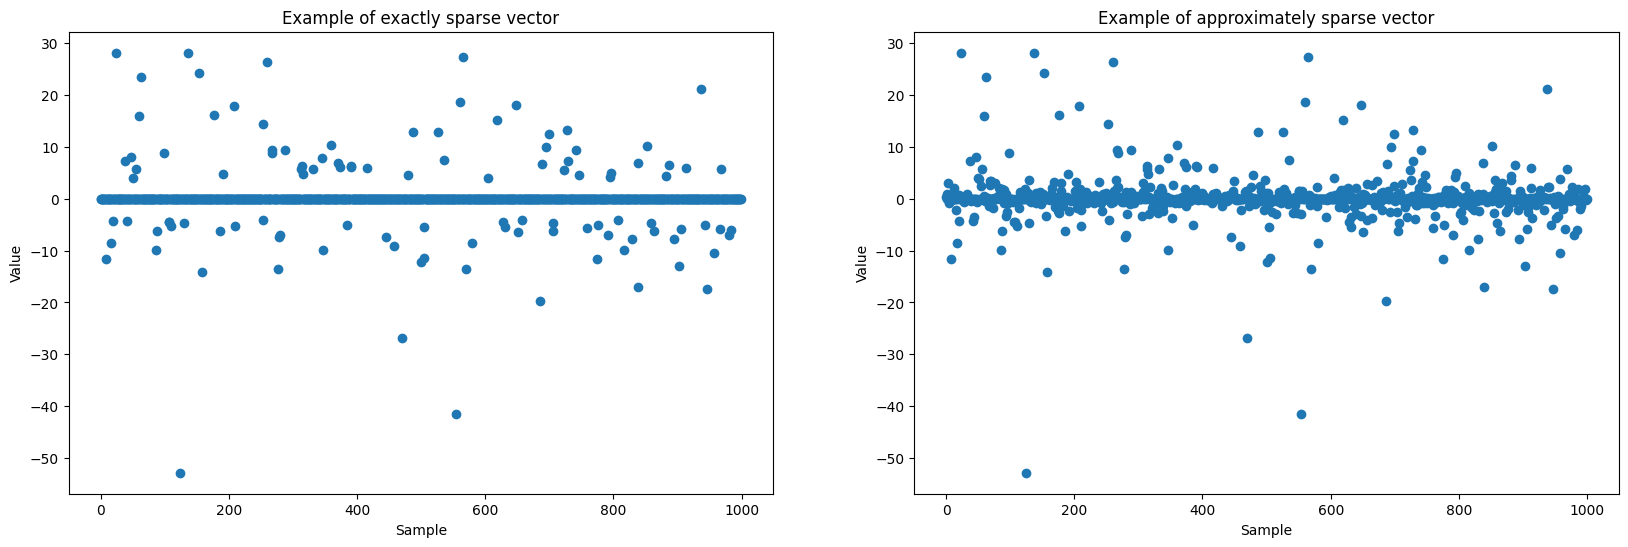

In [2]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

**Question:** What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

**Answer:**
- A signal $s \in \mathbb{R}^n$ is said to be exactly k-sparse if only $k << t$ of its element are non-zeros: $ ||s||_{0} = k ≪ t$
with the pseudo-norm $||.||_{0}$ being the cardinal of the support of $s$.  
- A signal $s \in \mathbb{R}^n$ is said to be approximately k-sparse when $||s||_{0} ≃ t$. When only a small number of the signal samples have a large amplitude, the signal can be well approximated by a k-sparse signal. This is for instance, if the sorted magnitudes of the signal samples follow a power law.

Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

First, generate a simulated source S matrix. Plot the corresponding scatter plot. 

**Question:** Interpret the shape of the scatter plot you obtain.

**Answer:** As we seen in the course, due to sparsity, the scatter plot of the sources has a star shape. Lines are the directions of the spectrum. Lines are orthogonal becauses the sources are sparse.

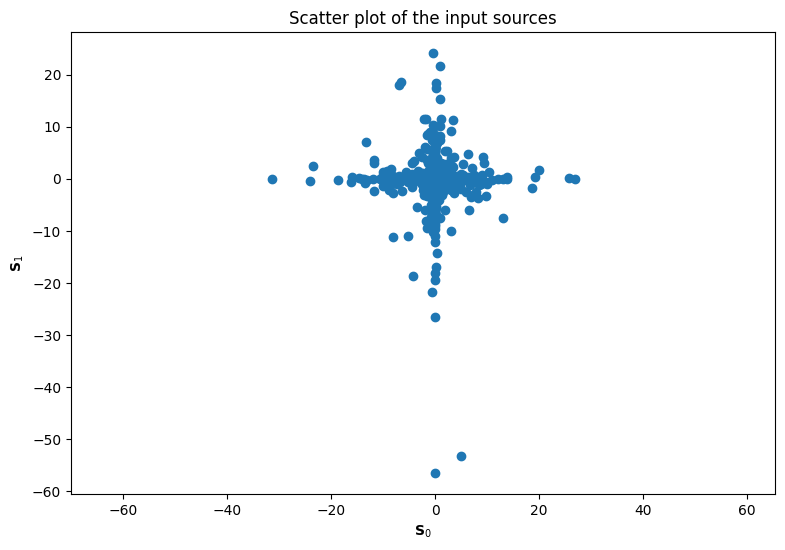

In [3]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 3 # power exponent used in the source generation



# TO DO : generate a simulated source S matrix. 
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse 
# law we used above.

S = np.zeros((n,t)) # TO CHANGE
for i in range(n):
    S[i,:] = np.random.randn(t)**power

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

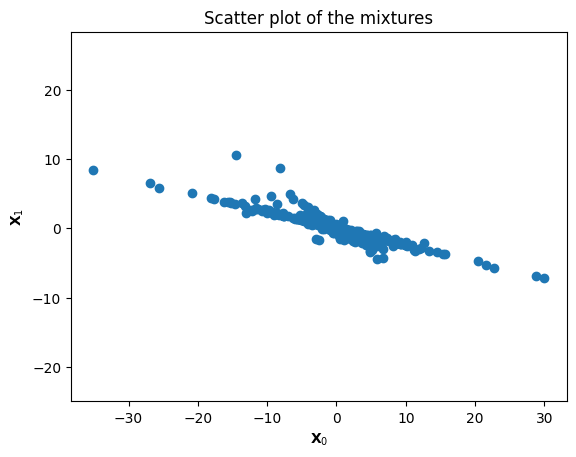

In [4]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S  
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 100

# To be more realistic, we add some noise to the mixing. 
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120: 
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

#--- Plot the mixtures and the dirrection of the sources
fig.add_subplot(1,2,2)
plt.title('Scatter plot of the mixtures')
plt.plot(X[0, :], X[1, :], 'C0o')
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

**Question:** Plot the scatter plot of X. What do you see ? 

**Answer:** X is the sources matric S multiplied by the mixing matrix A, which changes the dioection of the lines.

**Question:** What do the directions of the lines you observe correspond ?

**Answer:** The direction of the lines are the columns of the mixing matrix A.

**Question:** Try several A matrices, noise_values and powers. Any comment?

**Answer:** The noise_values add points out of the cross (which happens with a low probability without). Increasing the power make the points that are near to 0 more close to 0. The A matrix changes the direction of the lines.

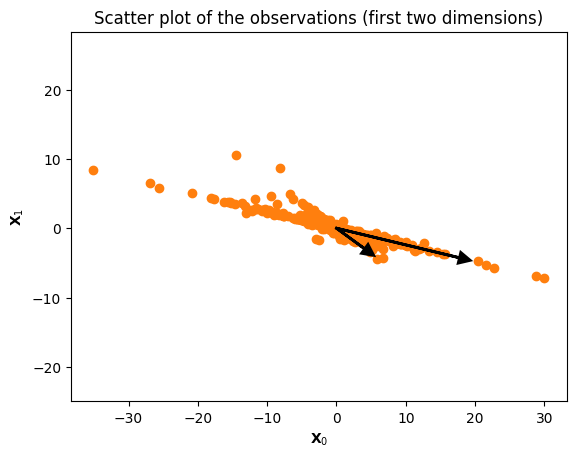

In [5]:
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals. The methodology extends to more complex datasets.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

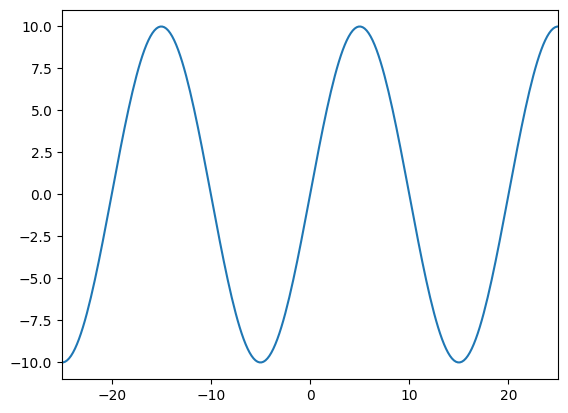

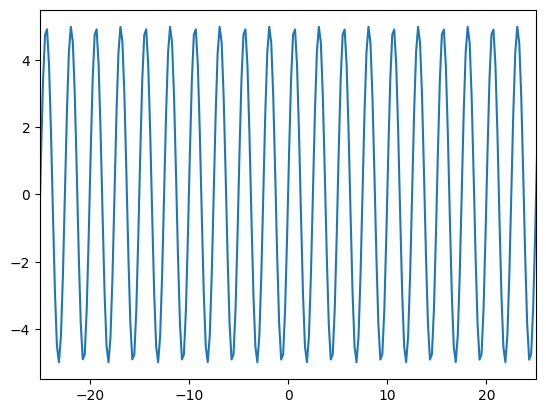

In [6]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

Here, we will transform the sources signals S into the DCT domain.

**Question:** What is the objective of using the DCT?

**Answer:** The Direct Cosinus Transform is a way to transform a sequence of data points into a sum of cosine functions.
After mixing signals, DCT will allow us to separate the signals using the inversibility of the DCT.

(<Figure size 640x480 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x186f320c510>])

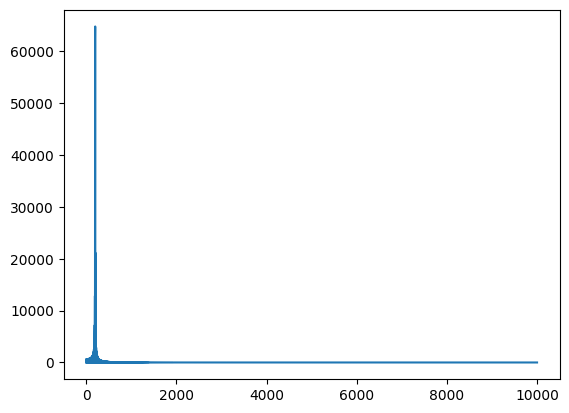

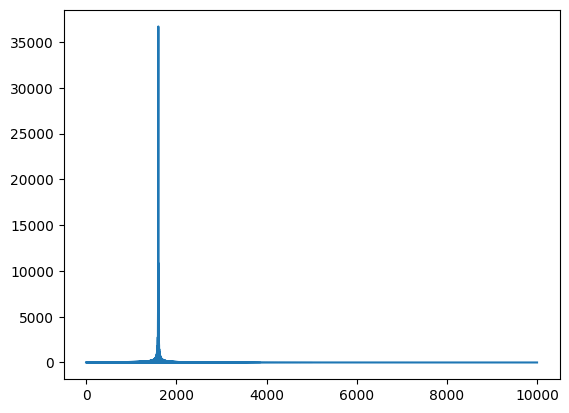

In [7]:
# Transformation into the DCT domain
Sf = sff.dct(S)

plt.figure(), plt.plot(np.absolute(Sf[0]))
plt.figure(), plt.plot(np.absolute(Sf[1]))


Data generation : now, we will create a mixture X = AS + N.

**Question:** Plot the mixtures. Explain what you see.  
**Answer:** The mixture is a sum of sinusoids, with a noise.

**Question:** Compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?  
**Answer:** Thanks to the DCT, we can see that the two sources. The caracteristic of the DCT that we will use to recover the sources is it's inversibility.

(<Figure size 640x480 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x186f59b5d10>])

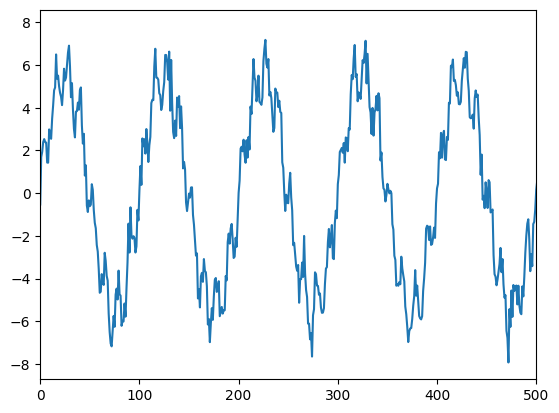

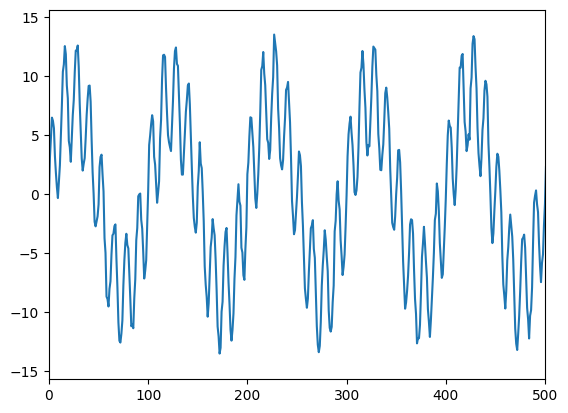

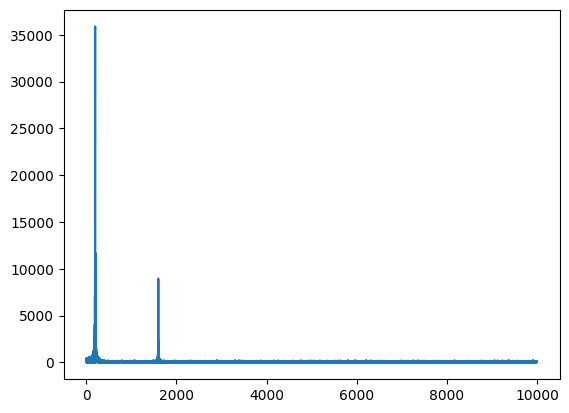

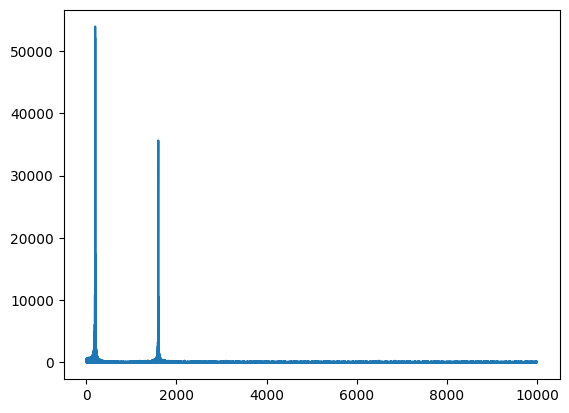

In [8]:
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A values, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

# Plot the mixtures 
plt.figure(), plt.plot(X[0,:])
plt.xlim([0,500])
plt.figure(), plt.plot(X[1,:])
plt.xlim([0,500])

#Compute the DCT of X 

Xf = sff.dct(X)

plt.figure(), plt.plot(np.absolute(Xf[0,:]))
plt.figure(), plt.plot(np.absolute(Xf[1,:]))

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

**Question:** First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?  
**Answer:**
The cost functionis $argmin_{A \in \mathbb{R}^{m \times n},S \in \mathbb{R}^{n \times t}}\frac{1}{2}||X-AS||^2_F +\lambda||S||_1$, with 
- $\frac{1}{2}||X-AS||^2_F$ as the Data-fidelity term. It is smooth.
- $\lambda||S||_1$ as the Sparsity term. It is non-smooth because of the $||.||_1$ term.

This cost function is convex because it is the sum of two convex functions (A is fixed).

**Question:** Compute the gradient along the S variable of the data-fidelity term.
**Answer:** The gradient along the S variable of the data-fidelity term is $-A^T(X-AS)$.

**Question:** Recall what the proximal operator of the l1-norm is.
**Answer:** The proximal operator of the $l_1$ norm is the soft-thresholding operator :

$(prox_{\lambda |.||_1}(v))_i =  \begin{cases} 
      v_i-\lambda &, v_i \ge \lambda \\
      0 &, -\lambda \le v_i\  \le \lambda \\
      v_i+\lambda &, v_i \le -\lambda
\end{cases} = sign(v_i)(|v_i|-\lambda)_+$

In [9]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est,thrd):
    S_est = np.sign(S_est)*np.maximum(np.abs(S_est)-thrd,0)
    return S_est

**Question:** Explain the main idea of the ISTA algorithm. Then, implement it.
**Answer:** The main idea of the ISTA algorithm is to use both the gradient descent method applied to the S variable of the data-fidelity term and the proximal operator of the $l_1$ norm of the soft-thresholding operator to minimize the cost function.

In [10]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):
    S_est = np.zeros((A.shape[1],X.shape[1]))
    gamma = 0.9/np.linalg.norm(np.matmul(A.T,A))
    for i in range(nbIt):
        S_est = prox_l1(S_est - gamma*(np.matmul(A.T,(np.matmul(A,S_est)-X))),lamb)  
    return S_est

It's now time to play with the code : launch the ISTA algorithm and look at the results.

**Question:** Try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?  
**Answer:** The minimum value we should not go below is 0. With $\lambda \leq 0$ , we won’t get sparce results. Increasing $\lambda$ increases the regularization, which means that the solution will be more sparse. But if $\lambda$ is too big, the solution will be too sparse and we will lose information.

In [11]:
S_estf = ISTA(Xf,A = A,n=2,lamb=1000,nbIt = 1000)



Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?

(<Figure size 640x480 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x186f613d590>])

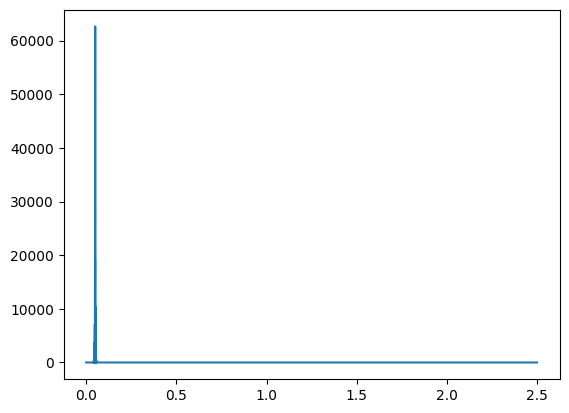

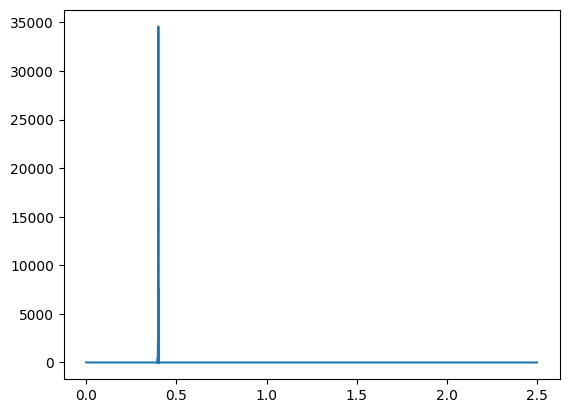

In [12]:
plt.figure(),plt.plot(np.linspace(0,2.5,t),np.absolute(S_estf[0]))
plt.figure(),plt.plot(np.linspace(0,2.5,t),np.absolute(S_estf[1]))


Transform the sources back in the direct domain. Plot them. 

**Question:** What do you see? Explain the differences with the original sources. Conclude.  
**Answer:** We obtain the original sinus signals from our ISTA estimation of S. The difference with the original sources is a scaling factor of 20000.

(-25.0, 25.0)

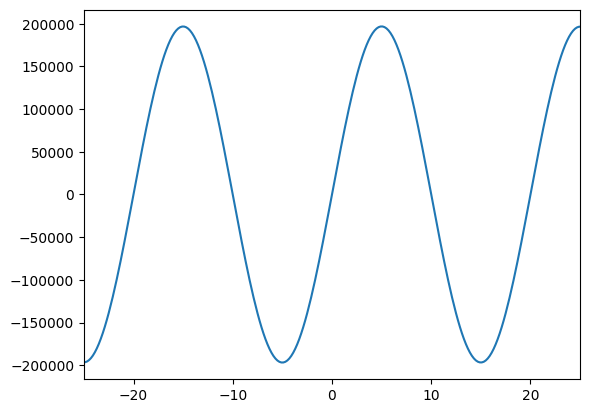

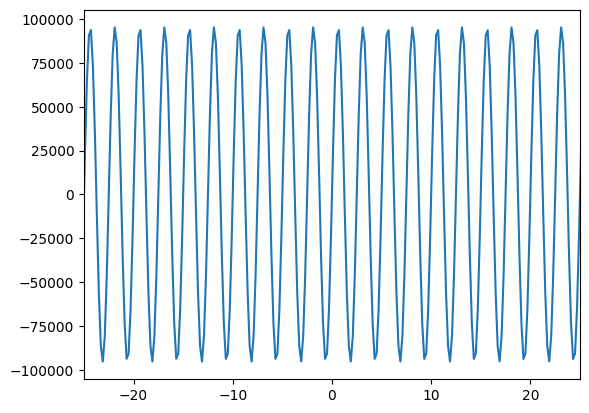

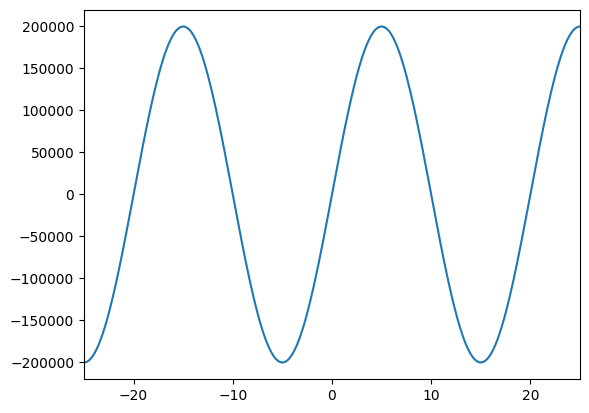

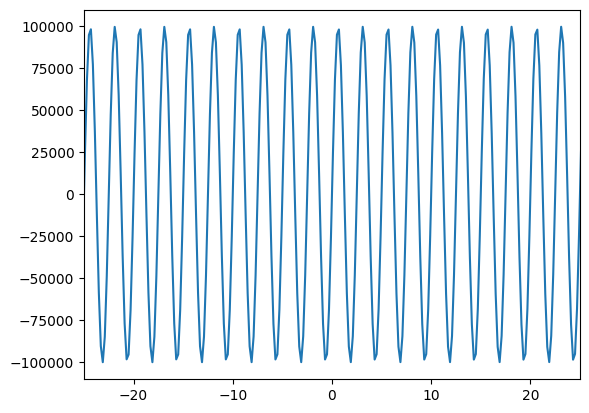

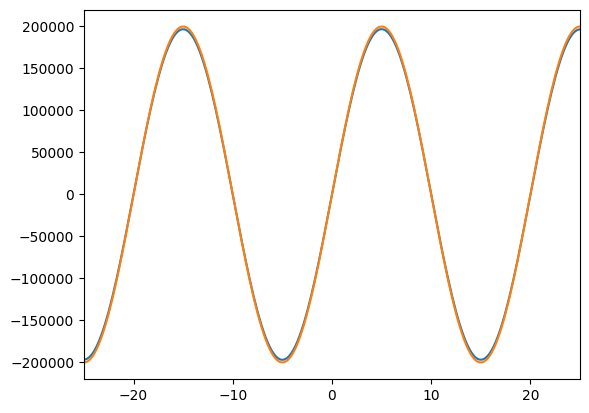

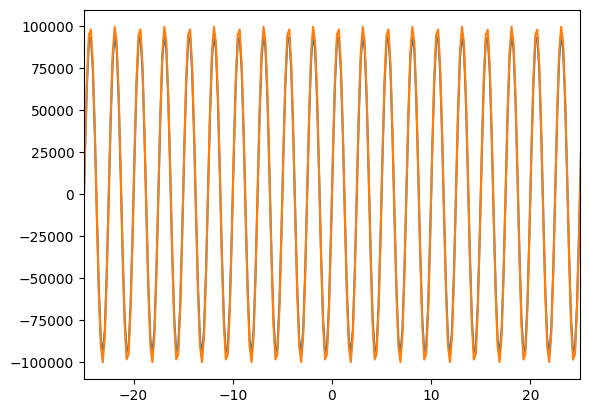

In [13]:
Sf = sff.idct(S_estf)

plt.figure(),plt.plot(x_abs, Sf[0])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs, Sf[1])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs, S[0]*20000)
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs, S[1]*20000)
plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs, Sf[0])
plt.xlim([-25,25])
plt.plot(x_abs, S[0]*20000)
plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs, Sf[1])
plt.xlim([-25,25])
plt.plot(x_abs, S[1]*20000)
plt.xlim([-25,25])

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

**Question:** Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?

**Answer:** The cost function is $argmin_{A \in \mathbb{R}^{m \times n},S \in \mathbb{R}^{n \times t}}\frac{1}{2}||X-AS||^2_F +\lambda||S||_1+\iota_{\{\forall i \in [1,n];||a_{:,j}||^2_{l_2}\le1\}}(A)$, with

- $\frac{1}{2}||X-AS||^2_F$ as the Data-fidelity term. It is smooth.
- $\lambda||S||_1$ as the Sparsity term. It is non-smooth because of the $||.||_1$ term.
- $\iota_{\{\forall i \in [1,n];||a_{:,j}||^2_{l_2}\le1\}}(A)$ as the constraint on A. It is non-smooth because of the indicator function.

This cost function is not convex because of the oblique constraint.




**Question:** Recall what the gradient of the data fidelity term over A is.  
**Answer:** The gradient along the S variable of the data-fidelity term is $-A^T(X-AS)$.

**Question:** Compute the proximal operator of the oblique constraint. Implement it.  
**Answer:** The proximal operator of the oblique constraint is the projection operator on the oblique constraint. It is implemented below.

In [14]:
def prox_oblique(A):
    for j in range(A.shape[1]):
        A[:, j] = A[:, j]/max(1, np.linalg.norm(A[:, j]))    
    return A

Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [15]:
def PALM(X,n=2,lamb=0,nbIt = 100):
    S_est = np.zeros((n,X.shape[1]))
    A_est = np.eye(X.shape[0],n)
    for i in range(nbIt):
      S_est = prox_l1(S_est + (0.9/(np.linalg.norm(A_est.T @ A_est)+1e-16))*(np.dot(A_est.T,(X - np.dot(A_est,S_est)))), lamb)
      A_est = prox_oblique(A_est + (0.9/(np.linalg.norm(S_est @ S_est.T)+1e-16))*np.dot((X - np.dot(A_est,S_est)),S_est.T))
    return A_est,S_est

Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

A : [[0.5547002  0.24253563]
 [0.83205029 0.9701425 ]]
A_est :  [[0.55435141 0.24473045]
 [0.83228271 0.96959115]]


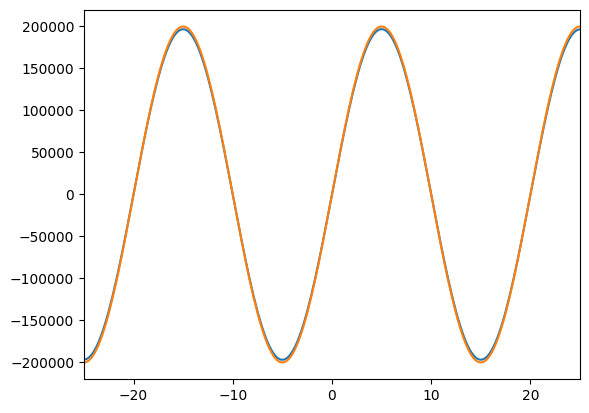

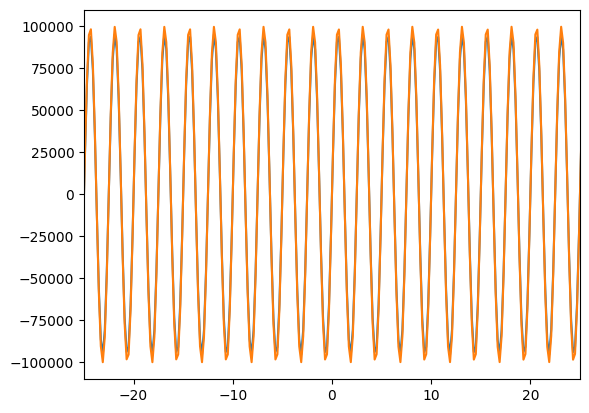

In [16]:
A_fest, S_fest = PALM(Xf, n=2, lamb=1000, nbIt=1000)

S_fest = sff.idct(S_fest)

plt.figure()
plt.plot(x_abs, S_fest[0])
plt.plot(x_abs,200000*np.sin(2*np.pi*0.05*x_abs))
plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs, S_fest[1])
plt.plot(x_abs,100000*np.sin(2*np.pi*0.4*x_abs))
plt.xlim([-25,25])

print('A :',A)
print('A_est : ',A_fest)

The separation quality is high, we obtain a signal similar to the original one. The A matrix is also similar to the original one, as we can see in the printed values above.